Fer2013 dataset is a common dataset used for facial expression recognition. The dataset contains 35,887 grayscale facial images containing 7 different emotions (anger, disgust, fear, happiness, neutral, sad, and surprise).



In [ ]:
import math
import numpy as np
import pandas as pd

import cv2
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from tensorflow.keras.utils import np_utils


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/DeepLeaningDataset/fer2013.csv'
data = pd.read_csv(file_path)

In [ ]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

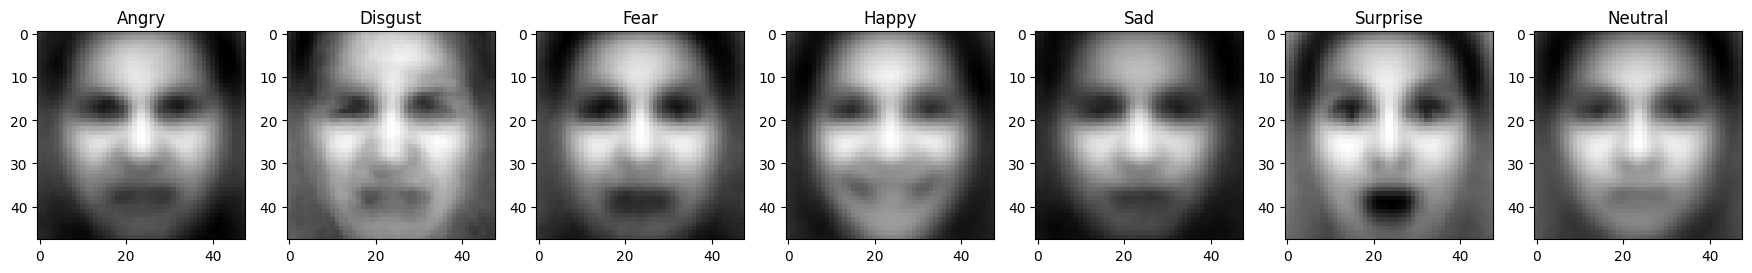

In [ ]:
import matplotlib.pyplot as plt

dic = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
from sklearn.model_selection import train_test_split

# Split your data into features (X) and labels (y)
XX = data.iloc[:,[1]]  # Assuming 'emotion' is the label column
yy = data.iloc[:,[0]]

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.3, random_state=42)

# Now you have XX_train, XX_test, yy_train, and yy_test for your model training and testing.


# Assuming you have DataFrames 'XX_train' and 'yy_train'
# Replace 'XX_train' and 'yy_train' with your actual DataFrame names

# Number of classes
num_classes = len(dic)

# Create subplots for each class
fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(22, 8))

# Loop through each class
for i, ax in enumerate(axes):
    # Filter images for the current class
    class_images = XX_train[yy_train['emotion'] == i]['pixels'].str.split().apply(lambda x: [int(val) for val in x])

    if not class_images.empty:  # Check if there are images for this class
        # Calculate the mean image for the class
        mean_image = np.mean(class_images.tolist(), axis=0).reshape(48, 48)

        # Display the mean image
        ax.imshow(mean_image, cmap='gray')  # Assuming grayscale images
        ax.set_title(dic[i])
    else:
        ax.set_title(dic[i] + " (No Data)")

plt.show()

In [ ]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
img_array = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [ ]:
img_array.shape

(35887, 48, 48)

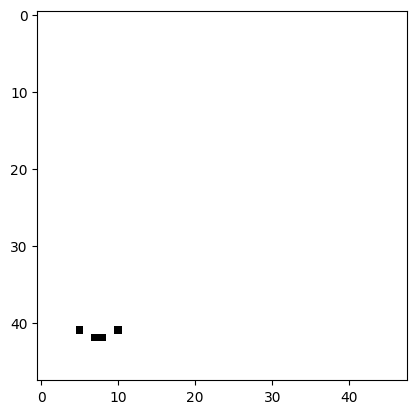

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming img_array is already created as per your code

# Stack the individual 2D images into a 3D array
composite_image = np.stack([img_array]*3, axis=-1)

# Display the composite image
plt.imshow(composite_image[1], cmap='gray')  # Display the second image in the composite
plt.show()

In [ ]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
img_labels = le.fit_transform(data.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape


(35887, 7)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features,
                                                      img_labels,
                                                      shuffle = True,
                                                      stratify = img_labels,
                                                      test_size = 0.1,
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [ ]:
#class_weight = {
#    0: 1 / (y_train['emotion'] == 0).sum(),
#   1: 1 / (y_train['emotion'] == 1).sum(),
#    2: 1 / (y_train['emotion'] == 2).sum(),
#    3: 1 / (y_train['emotion'] == 3).sum(),
#    4: 1 / (y_train['emotion'] == 4).sum(),
#    5: 1 / (y_train['emotion'] == 5).sum(),
#    6: 1 / (y_train['emotion'] == 6).sum()
#}

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
num_classes

7

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.

# Building the model

In [ ]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)

    return model

In [ ]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [ ]:
# batch size of 32 performs the best.
batch_size = 32
epochs = 5
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_datagen.flow(X_train,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/5
1009/1009 [==============================] - 77s 61ms/step - loss: 1.4686 - accuracy: 0.4266 - val_loss: 1.2106 - val_accuracy: 0.5280 - lr: 1.0000e-04
Epoch 2/5
1009/1009 [==============================] - 61s 60ms/step - loss: 1.2360 - accuracy: 0.5294 - val_loss: 1.1105 - val_accuracy: 0.5821 - lr: 1.0000e-04
Epoch 3/5
1009/1009 [==============================] - 63s 62ms/step - loss: 1.1419 - accuracy: 0.5700 - val_loss: 1.0909 - val_accuracy: 0.5935 - lr: 1.0000e-04
Epoch 4/5
1009/1009 [==============================] - 61s 61ms/step - loss: 1.0890 - accuracy: 0.5860 - val_loss: 1.0324 - val_accuracy: 0.6096 - lr: 1.0000e-04
Epoch 5/5
1009/1009 [==============================] - 62s 61ms/step - loss: 1.0484 - accuracy: 0.6074 - val_loss: 1.0752 - val_accuracy: 0.5946 - lr: 1.0000e-04


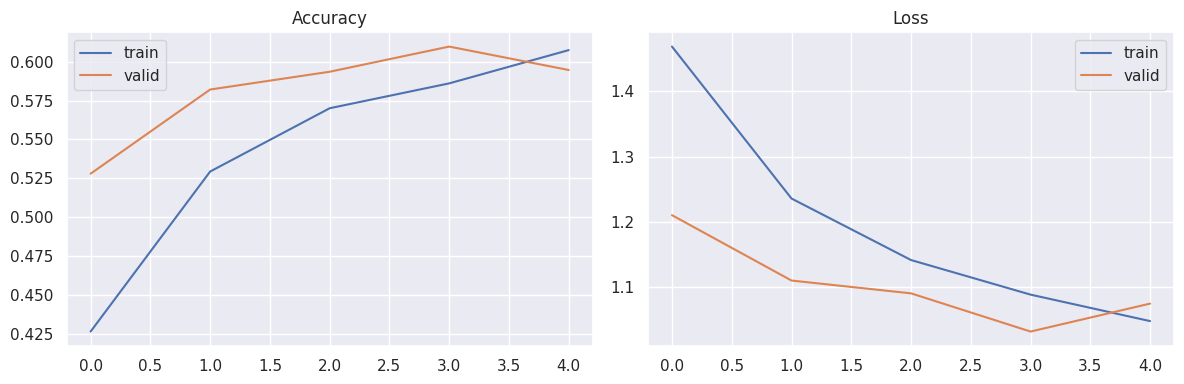

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [ ]:
pip install scikit-plot

In [ ]:
import scikitplot as skplt

In [ ]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

113/113 [==============================] - 2s 14ms/step


NameError: ignored

In [ ]:
data = [
    "Epoch 1/25 1009/1009 [==============================] - 65s 55ms/step - loss: 1.4653 - accuracy: 0.4265 - val_loss: 1.2158 - val_accuracy: 0.5341 - lr: 1.0000e-04",
"Epoch 2/25 1009/1009 [==============================] - 65s 65ms/step - loss: 1.2350 - accuracy: 0.5302 - val_loss: 1.1193 - val_accuracy: 0.5798 - lr: 1.0000e-04",
"Epoch 3/25 1009/1009 [==============================] - 56s 55ms/step - loss: 1.1501 - accuracy: 0.5648 - val_loss: 1.0835 - val_accuracy: 0.5957 - lr: 1.0000e-04",
"Epoch 4/25 1009/1009 [==============================] - 56s 55ms/step - loss: 1.0922 - accuracy: 0.5869 - val_loss: 1.0299 - val_accuracy: 0.6216 - lr: 1.0000e-04",
"Epoch 5/25 1009/1009 [==============================] - 56s 56ms/step - loss: 1.0534 - accuracy: 0.6035 - val_loss: 1.0138 - val_accuracy: 0.6202 - lr: 1.0000e-04",
"Epoch 6/25 1009/1009 [==============================] - 56s 56ms/step - loss: 1.0129 - accuracy: 0.6221 - val_loss: 0.9791 - val_accuracy: 0.6328 - lr: 1.0000e-04",
"Epoch 7/25 1009/1009 [==============================] - 56s 56ms/step - loss: 0.9820 - accuracy: 0.6306 - val_loss: 0.9859 - val_accuracy: 0.6330 - lr: 1.0000e-04",
"Epoch 8/25 1009/1009 [==============================] - 56s 56ms/step - loss: 0.9519 - accuracy: 0.6463 - val_loss: 0.9614 - val_accuracy: 0.6456 - lr: 1.0000e-04",
"Epoch 9/25 1009/1009 [==============================] - 56s 55ms/step - loss: 0.9286 - accuracy: 0.6516 - val_loss: 0.9285 - val_accuracy: 0.6478 - lr: 1.0000e-04",
"Epoch 10/25 1009/1009 [==============================] - 57s 56ms/step - loss: 0.9037 - accuracy: 0.6631 - val_loss: 0.9402 - val_accuracy: 0.6537 - lr: 1.0000e-04",
"Epoch 11/25 1009/1009 [==============================] - 56s 56ms/step - loss: 0.8825 - accuracy: 0.6712 - val_loss: 0.9200 - val_accuracy: 0.6682 - lr: 1.0000e-04",
"Epoch 12/25 1009/1009 [==============================] - 56s 55ms/step - loss: 0.8659 - accuracy: 0.6805 - val_loss: 0.9275 - val_accuracy: 0.6584 - lr: 1.0000e-04",
"Epoch 13/25 1009/1009 [==============================] - 56s 56ms/step - loss: 0.8433 - accuracy: 0.6848 - val_loss: 0.9231 - val_accuracy: 0.6670 - lr: 1.0000e-04",
"Epoch 14/25 1009/1009 [==============================] - 57s 56ms/step - loss: 0.8213 - accuracy: 0.6976 - val_loss: 0.9310 - val_accuracy: 0.6617 - lr: 1.0000e-04",
"Epoch 15/25 1009/1009 [==============================] - 56s 55ms/step - loss: 0.8100 - accuracy: 0.7012 - val_loss: 0.9243 - val_accuracy: 0.6562 - lr: 1.0000e-04",
"Epoch 16/25 1009/1009 [==============================] - 56s 55ms/step - loss: 0.7859 - accuracy: 0.7098 - val_loss: 0.8922 - val_accuracy: 0.6838 - lr: 1.0000e-04",
"Epoch 17/25 1009/1009 [==============================] - 57s 56ms/step - loss: 0.7632 - accuracy: 0.7189 - val_loss: 0.9205 - val_accuracy: 0.6673 - lr: 1.0000e-04",
"Epoch 18/25 1009/1009 [==============================] - 57s 56ms/step - loss: 0.7454 - accuracy: 0.7258 - val_loss: 0.9394 - val_accuracy: 0.6762 - lr: 1.0000e-04",
"Epoch 19/25 1009/1009 [==============================] - 56s 56ms/step - loss: 0.7281 - accuracy: 0.7315 - val_loss: 0.9081 - val_accuracy: 0.6746 - lr: 1.0000e-04",
"Epoch 20/25 1009/1009 [==============================] - 56s 56ms/step - loss: 0.7059 - accuracy: 0.7419 - val_loss: 0.9463 - val_accuracy: 0.6679 - lr: 1.0000e-04",
"Epoch 21/25 1009/1009 [==============================] - 57s 56ms/step - loss: 0.6963 - accuracy: 0.7441 - val_loss: 0.8965 - val_accuracy: 0.6821 - lr: 1.0000e-04",
"Epoch 22/25 1009/1009 [==============================] - 56s 56ms/step - loss: 0.6756 - accuracy: 0.7525 - val_loss: 0.9041 - val_accuracy: 0.6871 - lr: 1.0000e-04",
"Epoch 23/25 1009/1009 [==============================] - 56s 56ms/step - loss: 0.6620 - accuracy: 0.7608 - val_loss: 0.9075 - val_accuracy: 0.6771 - lr: 1.0000e-04",
"Epoch 24/25 1009/1009 [==============================] - 57s 56ms/step - loss: 0.6476 - accuracy: 0.7635 - val_loss: 0.9661 - val_accuracy: 0.6707 - lr: 1.0000e-04",
"Epoch 25/25 1009/1009 [==============================] - 56s 55ms/step - loss: 0.6269 - accuracy: 0.7715 - val_loss: 0.9455 - val_accuracy: 0.6821 - lr: 1.0000e-04"
]

# Initialize lists to store the metrics for each epoch
epochs = []
losses = []
accuracies = []
val_losses = []
val_accuracies = []

# Extract losses and accuracies for each epoch
for entry in data:
    parts = entry.split()
    epoch = int(parts[1].split('/')[0])
    loss = float(parts[11])
    accuracy = float(parts[14])
    val_loss = float(parts[17])
    val_accuracy = float(parts[20])

    epochs.append(epoch)
    losses.append(loss)
    accuracies.append(accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

# Create a table
import pandas as pd
table = pd.DataFrame({
    "Epoch": epochs,
    "Loss": losses,
    "Accuracy": accuracies,
    "Val_Loss": val_losses,
    "Val_Accuracy": val_accuracies
})

# Display the table
print(table)

ValueError: ignored

In [ ]:
data = [
"Epoch 1/20 4589/4589 [==============================] - 40s 8ms/step - loss: 0.2849 - accuracy: 0.8831 - val_loss: 0.2209 - val_accuracy: 0.9094",
"Epoch 2/20 4589/4589 [==============================] - 35s 8ms/step - loss: 0.2098 - accuracy: 0.9127 - val_loss: 0.1990 - val_accuracy: 0.9186",
"Epoch 3/20 4589/4589 [==============================] - 36s 8ms/step - loss: 0.1931 - accuracy: 0.9195 - val_loss: 0.2000 - val_accuracy: 0.9177",
"Epoch 4/20 4589/4589 [==============================] - 35s 8ms/step - loss: 0.1837 - accuracy: 0.9234 - val_loss: 0.1993 - val_accuracy: 0.9168",
"Epoch 5/20 4589/4589 [==============================] - 35s 8ms/step - loss: 0.1766 - accuracy: 0.9264 - val_loss: 0.2013 - val_accuracy: 0.9163",
"Epoch 6/20 4589/4589 [==============================] - 35s 8ms/step - loss: 0.1708 - accuracy: 0.9287 - val_loss: 0.2044 - val_accuracy: 0.9174",
"Epoch 7/20 4589/4589 [==============================] - 36s 8ms/step - loss: 0.1656 - accuracy: 0.9309 - val_loss: 0.2164 - val_accuracy: 0.9166",
"Epoch 8/20 4589/4589 [==============================] - 35s 8ms/step - loss: 0.1606 - accuracy: 0.9332 - val_loss: 0.2122 - val_accuracy: 0.9155",
"Epoch 9/20 4589/4589 [==============================] - 35s 8ms/step - loss: 0.1560 - accuracy: 0.9354 - val_loss: 0.2203 - val_accuracy: 0.9170",
"Epoch 10/20 4589/4589 [==============================] - 36s 8ms/step - loss: 0.1515 - accuracy: 0.9373 - val_loss: 0.2222 - val_accuracy: 0.9161",
"Epoch 11/20 4589/4589 [==============================] - 35s 8ms/step - loss: 0.1468 - accuracy: 0.9396 - val_loss: 0.2225 - val_accuracy: 0.9143",
"Epoch 12/20 4589/4589 [==============================] - 37s 8ms/step - loss: 0.1427 - accuracy: 0.9413 - val_loss: 0.2330 - val_accuracy: 0.9120",
"Epoch 13/20 4589/4589 [==============================] - 36s 8ms/step - loss: 0.1386 - accuracy: 0.9432 - val_loss: 0.2369 - val_accuracy: 0.9131",
"Epoch 14/20 4589/4589 [==============================] - 34s 7ms/step - loss: 0.1344 - accuracy: 0.9455 - val_loss: 0.2418 - val_accuracy: 0.9102",
"Epoch 15/20 4589/4589 [==============================] - 36s 8ms/step - loss: 0.1307 - accuracy: 0.9470 - val_loss: 0.2487 - val_accuracy: 0.9073",
"Epoch 16/20 4589/4589 [==============================] - 37s 8ms/step - loss: 0.1272 - accuracy: 0.9490 - val_loss: 0.2574 - val_accuracy: 0.9058",
"Epoch 17/20 4589/4589 [==============================] - 36s 8ms/step - loss: 0.1237 - accuracy: 0.9502 - val_loss: 0.2663 - val_accuracy: 0.9009",
"Epoch 18/20 4589/4589 [==============================] - 36s 8ms/step - loss: 0.1202 - accuracy: 0.9519 - val_loss: 0.2734 - val_accuracy: 0.9028",
"Epoch 19/20 4589/4589 [==============================] - 36s 8ms/step - loss: 0.1173 - accuracy: 0.9536 - val_loss: 0.2810 - val_accuracy: 0.8978",
"Epoch 20/20 4589/4589 [==============================] - 36s 8ms/step - loss: 0.1144 - accuracy: 0.9550 - val_loss: 0.2959 - val_accuracy: 0.9058"]

# Initialize lists to store the metrics for each epoch
epochs = []
losses = []
accuracies = []
val_losses = []
val_accuracies = []

# Extract losses and accuracies for each epoch
for entry in data:
    parts = entry.split()
    epoch = int(parts[1].split('/')[0])

    loss = accuracy = val_loss = val_accuracy = None

    for i in range(len(parts)):
        if parts[i] == "loss:":
            loss = float(parts[i + 1])
        elif parts[i] == "accuracy:":
            accuracy = float(parts[i + 1])
        elif parts[i] == "val_loss:":
            val_loss = float(parts[i + 1])
        elif parts[i] == "val_accuracy:":
            val_accuracy = float(parts[i + 1])

    if None not in [loss, accuracy, val_loss, val_accuracy]:
        epochs.append(epoch)
        losses.append(loss)
        accuracies.append(accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

# Create a table
import pandas as pd
table = pd.DataFrame({
    "Epoch": epochs,
    "Loss": losses,
    "Accuracy": accuracies,
    "Val_Loss": val_losses,
    "Val_Accuracy": val_accuracies
})

# Display the table
print(table)

    Epoch    Loss  Accuracy  Val_Loss  Val_Accuracy
0       1  0.2849    0.8831    0.2209        0.9094
1       2  0.2098    0.9127    0.1990        0.9186
2       3  0.1931    0.9195    0.2000        0.9177
3       4  0.1837    0.9234    0.1993        0.9168
4       5  0.1766    0.9264    0.2013        0.9163
5       6  0.1708    0.9287    0.2044        0.9174
6       7  0.1656    0.9309    0.2164        0.9166
7       8  0.1606    0.9332    0.2122        0.9155
8       9  0.1560    0.9354    0.2203        0.9170
9      10  0.1515    0.9373    0.2222        0.9161
10     11  0.1468    0.9396    0.2225        0.9143
11     12  0.1427    0.9413    0.2330        0.9120
12     13  0.1386    0.9432    0.2369        0.9131
13     14  0.1344    0.9455    0.2418        0.9102
14     15  0.1307    0.9470    0.2487        0.9073
15     16  0.1272    0.9490    0.2574        0.9058
16     17  0.1237    0.9502    0.2663        0.9009
17     18  0.1202    0.9519    0.2734        0.9028
18     19  0

In [ ]:
table

,Epoch,Loss,Accuracy,Val_Loss,Val_Accuracy
0,1,1.4653,0.4265,1.2158,0.5341
1,2,1.2350,0.5302,1.1193,0.5798
2,3,1.1501,0.5648,1.0835,0.5957
3,4,1.0922,0.5869,1.0299,0.6216
4,5,1.0534,0.6035,1.0138,0.6202
5,6,1.0129,0.6221,0.9791,0.6328
6,7,0.9820,0.6306,0.9859,0.6330
7,8,0.9519,0.6463,0.9614,0.6456
8,9,0.9286,0.6516,0.9285,0.6478
9,10,0.9037,0.6631,0.9402,0.6537
